In [1]:
!pip install spacy --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textacy 0.10.1 requires spacy<3.0.0,>=2.2.0, but you have spacy 3.1.1 which is incompatible.
en-core-web-sm 2.3.1 requires spacy<2.4.0,>=2.3.0, but you have spacy 3.1.1 which is incompatible.
en-core-web-lg 2.3.1 requires spacy<2.4.0,>=2.3.0, but you have spacy 3.1.1 which is incompatible.
You should consider upgrading via the 'd:\anaconda3\python.exe -m pip install --upgrade pip' command.



  Using cached spacy-3.1.1-cp38-cp38-win_amd64.whl (12.0 MB)
  Using cached spacy_legacy-3.0.8-py2.py3-none-any.whl (14 kB)
  Using cached thinc-8.0.8-cp38-cp38-win_amd64.whl (1.0 MB)
  Using cached pydantic-1.8.2-cp38-cp38-win_amd64.whl (2.0 MB)
  Using cached pathy-0.6.0-py3-none-any.whl (42 kB)
  Using cached smart_open-5.1.0-py3-none-any.whl (57 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.5
    Uninstalling spacy-2.3.5:
      Successfully uninstalled spacy-2.3.5


In [2]:
import spacy
spacy.__version__

'3.1.1'

In [3]:
!python -m spacy download ru_core_news_sm

2021-08-02 11:55:34.748406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll


  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=5aa6ae6cf40ae1c08b79d77ad87d4ba68cd60e53beca62954eccd971bdf4357d
  Stored in directory: c:\users\altsoph\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')



You should consider upgrading via the 'd:\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import spacy
from spacy.lang.ru.examples import sentences 

nlp = spacy.load("ru_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple рассматривает возможность покупки стартапа из Соединённого Королевства за $1 млрд
Apple PROPN nsubj
рассматривает VERB ROOT
возможность NOUN obj
покупки NOUN nmod
стартапа NOUN nmod
из ADP case
Соединённого ADJ amod
Королевства PROPN nmod
за ADP case
$ SYM nmod
1 NUM appos
млрд NOUN punct


In [6]:
import csv

cancel = []
cause  = []
rels = []
same = []

records = []
with open("ru_news_cause_v1.tsv", "r", encoding='utf-8') as r:
    reader = csv.reader(r, delimiter="\t")
    header = next(reader)
    for row in reader:
        r = dict(zip(header, row))
        if float(r["confidence"]) < 0.69:
            continue
        result = r["result"]
        mapping = {
#             "bad": 0,
            "rel": 0,
            "same": 0,
            "left_right_cause": 0,
            "left_right_cancel": 1,
            "right_left_cause": 0,
            "right_left_cancel": 1
        }
        if result not in mapping:
            continue
        if result.startswith('right'):
            r['left_title'], r['right_title'] = r['right_title'], r['left_title']
        if result.endswith('cause'):
            cause.append( (r['left_title'], r['right_title']) )
        elif result.endswith('cancel'):
            cancel.append( (r['left_title'], r['right_title']) )
        elif result.endswith('same'):
            same.append( (r['left_title'], r['right_title']) )
        elif result.endswith('rel'):
            rels.append( (r['left_title'], r['right_title']) )

        r["label"] = mapping[result]
        records.append(r)

In [34]:
def get_verbs_lemmed(s):
    doc = nlp(s)
    negation_tokens = [tok for tok in doc if tok.dep_ == 'neg' or tok.lemma_ in ('не','передумать',
                            'отменить','отказаться')]
    negated_tokens = [child.lemma_ for token in negation_head_tokens for child in token.children]
    verbs = []
    for token in doc:
        if token.is_stop: continue
        if token.pos_ == 'VERB':
            if token.lemma_ in negated_tokens:
                verbs.append( 'не_'+token.lemma_ )
            else:
                verbs.append( token.lemma_ )
    return tuple(verbs)

def pairs2verbs(l):
    return tuple( [ (get_verbs_lemmed(s1), get_verbs_lemmed(s2)) for s1, s2 in l ] )

cancel_verbs = pairs2verbs(cancel)
cause_verbs = pairs2verbs(cause)
rels_verbs = pairs2verbs(rels)
same_verbs = pairs2verbs(same)
cancel_verbs

((('скончаться',), ('скончаться',)),
 (('не_вернуться',), ('не_вернуться', 'отправиться')),
 (('спрогнозировать',), ('опровергнуть',)),
 (('заболеть',), ('подтвердиться',)),
 (('начаться',), ('опровергнуть',)),
 (('объяснить',), ('опровергнуть',)),
 (('подать',), ('подать',)),
 (('обязать', 'устанавливать'), ('решить', 'перенести')),
 (('обвинить',), ('опровергнуть',)),
 (('стать', 'не_вернуться'), ('опровергнуть',)),
 (('стать', 'закрыть'), ('опровергнуть',)),
 (('отказаться', 'покидать'), ('не_вернуться',)),
 (('госпитализировать',), ('опровергнуть',)),
 (('предложить', 'хранить'), ('отказаться', 'хранить')),
 (('предупредить',), ('опровергнуть',)),
 (('задержать',), ('опровергнуть',)),
 (('приостановить',), ('снять',)),
 (('подать',), ('передумать', 'судиться')),
 (('стать',), ('опровергнуть',)),
 (('появиться', 'спасти'), ('опровергнуть',)),
 (('рассказать',), ('опровергнуть',)),
 (('назвать',), ('опровергнуть',)),
 (('покончить',), ('опровергнуть',)),
 (('спрогнозировать',), ('опр

In [39]:
from collections import Counter

def verbs2stats(pl):
    left_verbs = []
    right_verbs = []
    same_verbs = []
    pairs_verbs = []
    neg_pairs_verbs = []
    for vv1, vv2 in pl:
        left_verbs.extend(vv1)
        right_verbs.extend(vv2)
        same_verbs.extend(list(set(vv1)&set(vv2)))
        for v1 in vv1:
            for v2 in vv2:
                pairs_verbs.append( (v1,v2) )
                if (v1 in v2 or v2 in v1) and (v1.startswith('не_') or v2.startswith('не_')):
                    neg_pairs_verbs.append( (v1,v2) )
    print('\nleft verbs stats')
    print('\t'+'\n\t'.join(map(str, Counter(left_verbs).most_common(5))))
    print('\nright verbs stats')
    print('\t'+'\n\t'.join(map(str, Counter(right_verbs).most_common(5))))
    print('\nsame verbs stats')
    print('\t'+'\n\t'.join(map(str, Counter(same_verbs).most_common(5))))
    print('\npair verbs stats')
    print('\t'+'\n\t'.join(map(str, Counter(pairs_verbs).most_common(5))))
    print('\nneg pair verbs stats')
    print('\t'+'\n\t'.join(map(str, Counter(neg_pairs_verbs).most_common(5))))
    
    
print('CANCEL')
verbs2stats(cancel_verbs)
print('\nCAUSE')
verbs2stats(cause_verbs)
print('\nREL')
verbs2stats(rels_verbs)
print('\nSAME')
verbs2stats(same_verbs)


CANCEL

left verbs stats
	('стать', 11)
	('погибнуть', 6)
	('сообщить', 5)
	('отказаться', 4)
	('задержать', 4)

right verbs stats
	('опровергнуть', 66)
	('погибнуть', 6)
	('не_вернуться', 5)
	('снять', 5)
	('отказаться', 4)

same verbs stats
	('погибнуть', 5)
	('пропасть', 2)
	('признать', 2)
	('скончаться', 1)
	('не_вернуться', 1)

pair verbs stats
	(('стать', 'опровергнуть'), 9)
	(('погибнуть', 'погибнуть'), 5)
	(('рассказать', 'опровергнуть'), 3)
	(('отдать', 'опровергнуть'), 3)
	(('спрогнозировать', 'опровергнуть'), 2)

neg pair verbs stats
	(('не_вернуться', 'не_вернуться'), 1)
	(('вернуть', 'не_вернуться'), 1)

CAUSE

left verbs stats
	('умереть', 58)
	('задержать', 44)
	('найти', 38)
	('назвать', 34)
	('предложить', 33)

right verbs stats
	('отреагировать', 121)
	('раскрыть', 115)
	('объяснить', 104)
	('ответить', 87)
	('появиться', 85)

same verbs stats
	('задержать', 8)
	('назвать', 7)
	('обвинить', 6)
	('убить', 5)
	('пропасть', 5)

pair verbs stats
	(('умереть', 'раскрыть')

In [42]:
cancel_sim = [ nlp(s1).similarity(nlp(s2)) for s1, s2 in cancel ]
cause_sim = [ nlp(s1).similarity(nlp(s2)) for s1, s2 in cause ]
rels_sim = [ nlp(s1).similarity(nlp(s2)) for s1, s2 in rels ]
same_sim = [ nlp(s1).similarity(nlp(s2)) for s1, s2 in same ]



<ipython-input-42-732bcca40902>:1: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  cancel_sim = [ nlp(s1).similarity(nlp(s2)) for s1, s2 in cancel ]
<ipython-input-42-732bcca40902>:2: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors

In [47]:
import numpy as np
import scipy.stats

def stat_tests(sample1,sample2):
    try:
        mw = scipy.stats.mannwhitneyu(sample1,sample2,alternative='two-sided')[1]
    except:
        mw = "nan"
    tt = scipy.stats.ttest_ind(sample1,sample2)[1]
#     print(mw, tt)
    return (float(mw),float(tt))

def compare_similarities(v1, v2):
    ctl_proj = v1
    exp_proj = v2
    print(f'means',np.mean(v1), np.mean(v2))
    print(f'means diff',float(np.mean(ctl_proj)-np.mean(exp_proj)))
    print(f'stat tests', stat_tests(ctl_proj,exp_proj))

for t1,c1 in (('CANCEL', cancel_sim), ('CAUSE', cause_sim), ('RELS', rels_sim), ('SAME', same_sim), ):
    for t2,c2 in (('CANCEL', cancel_sim), ('CAUSE', cause_sim), ('RELS', rels_sim), ('SAME', same_sim), ):
        print(f'{t1} VS {t2}')
        compare_similarities(c1,c2)
        print()

CANCEL VS CANCEL
means 0.6158656016217712 0.6158656016217712
means diff 0.0
stat tests (0.999526793740703, 1.0)

CANCEL VS CAUSE
means 0.6158656016217712 0.5068351268025454
means diff 0.10903047481922579
stat tests (7.537285638532631e-10, 1.2118202710187373e-10)

CANCEL VS RELS
means 0.6158656016217712 0.46360273362198995
means diff 0.15226286799978123
stat tests (7.27080866206627e-18, 7.709113641376996e-20)

CANCEL VS SAME
means 0.6158656016217712 0.6142281814613949
means diff 0.0016374201603762684
stat tests (0.9516471840527773, 0.93228622377382)

CAUSE VS CANCEL
means 0.5068351268025454 0.6158656016217712
means diff -0.10903047481922579
stat tests (7.537285638532631e-10, 1.2118202710187373e-10)

CAUSE VS CAUSE
means 0.5068351268025454 0.5068351268025454
means diff 0.0
stat tests (0.9999793229131883, 1.0)

CAUSE VS RELS
means 0.5068351268025454 0.46360273362198995
means diff 0.04323239318055544
stat tests (5.754558540624688e-09, 2.5133922946659024e-08)

CAUSE VS SAME
means 0.50683512

In [51]:
from collections import Counter

def save_gdf(fn, pl):
    nodes = Counter()
    edges = Counter()
    for vv1, vv2 in pl:
        for v1 in vv1:
            nodes.update([v1,])
        for v2 in vv2:
            nodes.update([v2,])
        for v1 in vv1:
            for v2 in vv2:
                edges.update([(v1,v2)])
    with open(fn, 'w', encoding='utf-8') as fh:
        print('nodedef>name VARCHAR,label VARCHAR,cnt DOUBLE', file=fh)
        for n, c in nodes.items():
            print(f'{n},{n},{c}', file=fh)
        print('edgedef>node1 VARCHAR,node2 VARCHAR,directed BOOLEAN,label VARCHAR', file=fh)
        for nn, l  in edges.items():
            n1, n2 = nn
            print(f'{n1},{n2},true,{l}', file=fh)

save_gdf('cancel.gdf', cancel_verbs)
save_gdf('cause.gdf', cause_verbs)
save_gdf('rels.gdf', rels_verbs)
save_gdf('same.gdf', same_verbs)

## Cancel

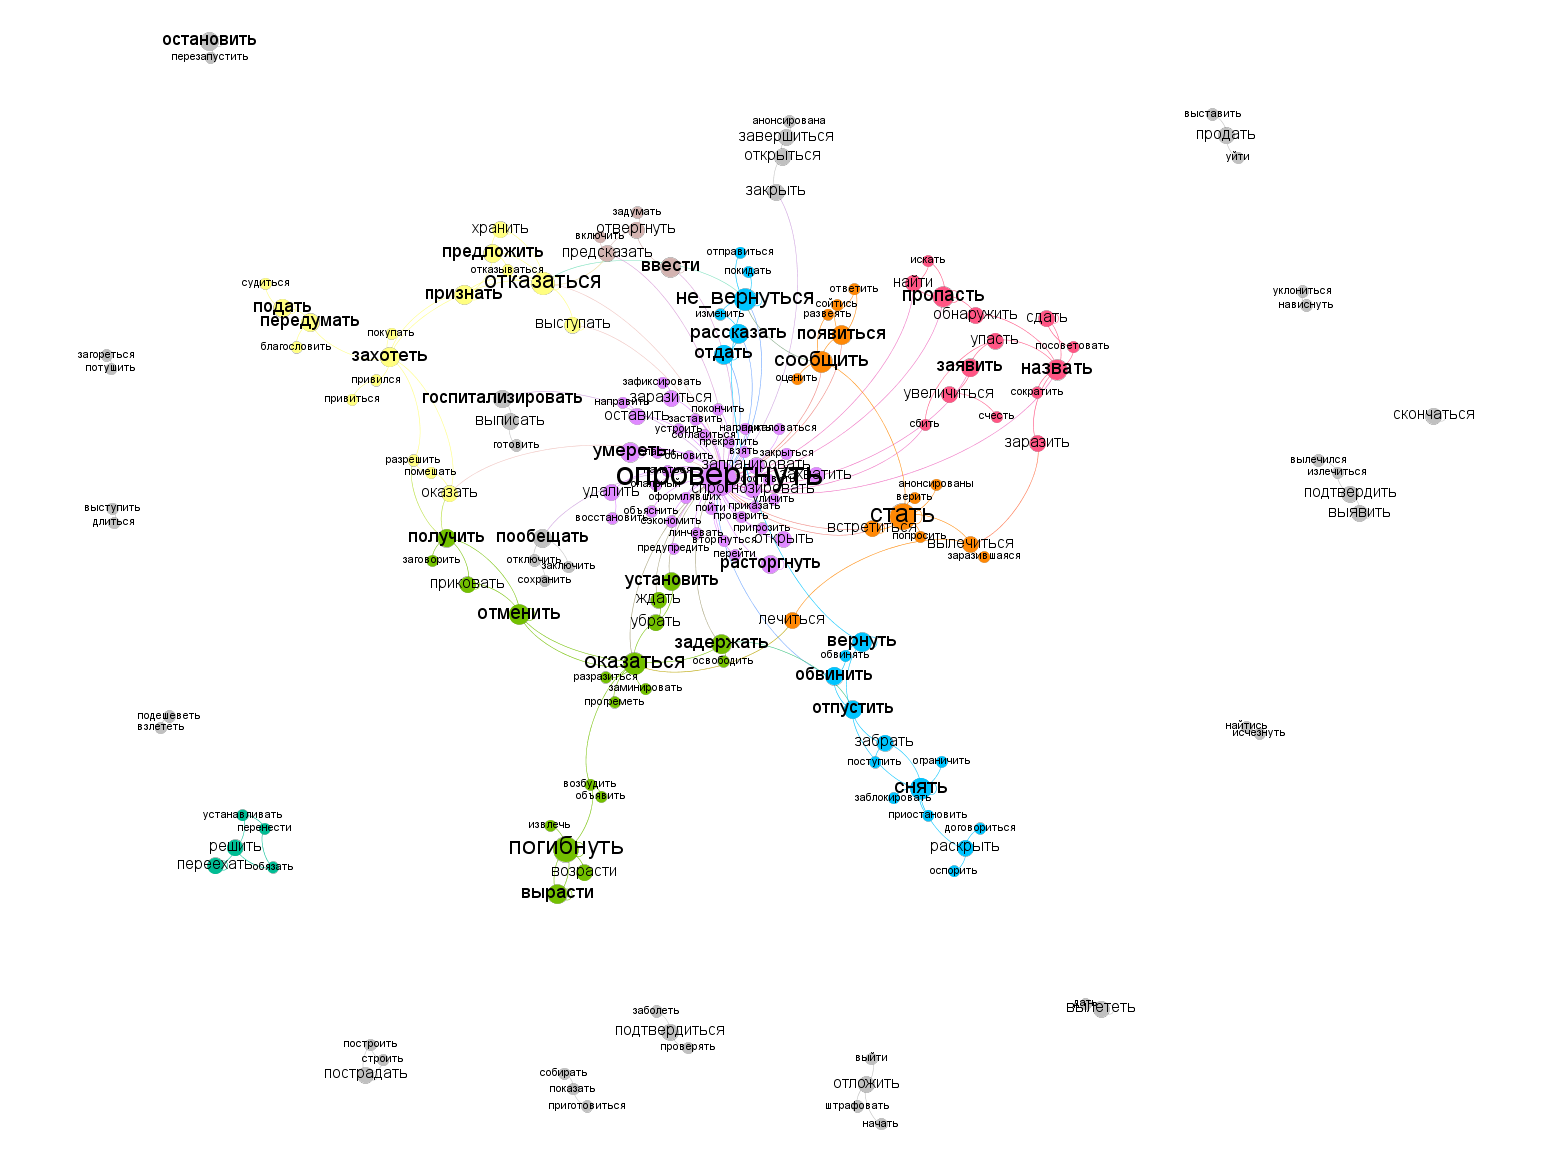


## Cause

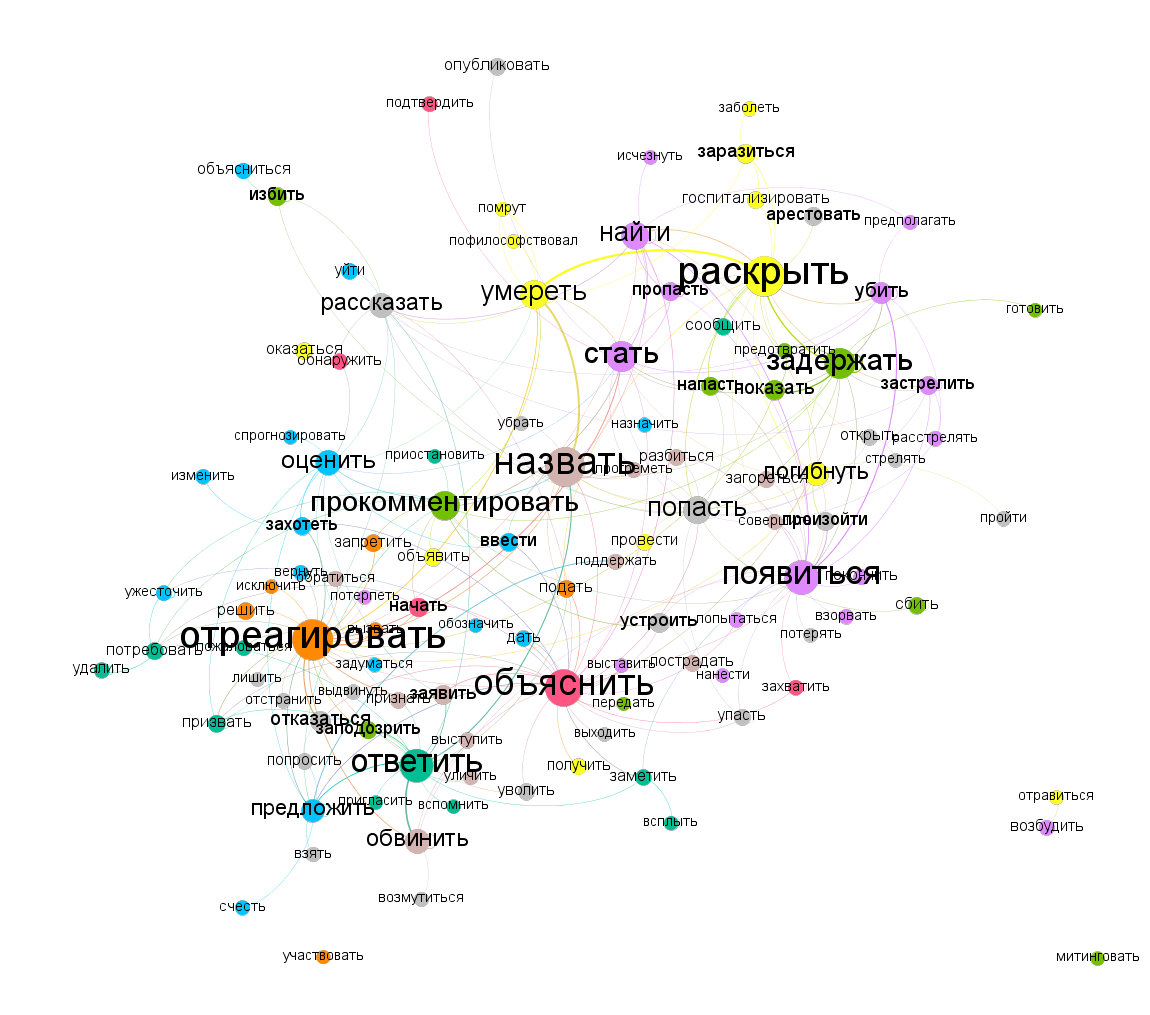